In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from numpy.linalg import norm
from matplotlib import pyplot as plt
from sklearn.linear_model import SGDRegressor
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
%matplotlib inline

from google.colab import drive
from pathlib import Path
drive.mount('/content/drive/')
path = Path('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Python/ML/non_linear.csv")
degree = 8

def generate_degrees(source_data: list, degree: int):
    """Функция, которая принимает на вход одномерный массив, а возвращает n-мерный
    Для каждой степени от 1 до  degree возводим x в эту степень
    """
    return np.array([
          source_data**n for n in range(1, degree + 1)  
    ]).T

X = generate_degrees(data['x_train'], degree)
y = data.y_train.values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)
model_R = Ridge(alpha=0.8).fit(X_train, y_train)
model_L = Lasso(alpha=0.8).fit(X_train, y_train)
R_coef = model_R.coef_
L_coef = model_L.coef_
print(R_coef)
print(L_coef)

[ 4.54261785e-01  3.41976833e-01  3.27582095e-02 -2.07134535e-01
  3.63216332e-02  1.18194113e-02 -3.68031928e-03  2.63585519e-04]
[-0.00000000e+00 -0.00000000e+00 -1.08299601e-02 -9.52247249e-03
  1.03490179e-03  1.87872250e-04  3.38785318e-06 -2.14838285e-06]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7134369621139607, tolerance: 0.002448155578496404
  positive)


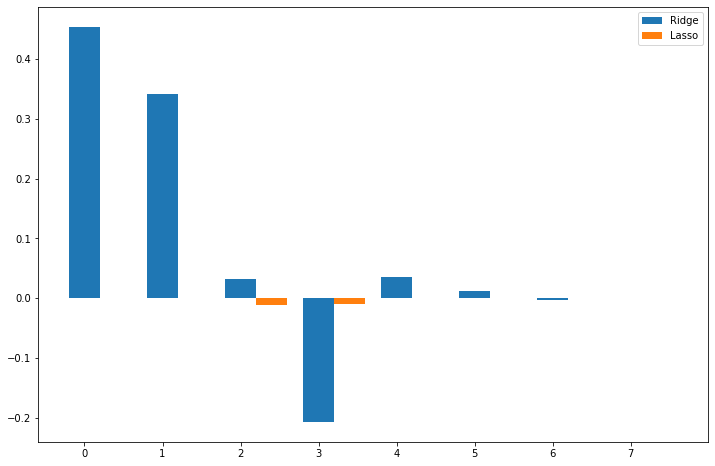

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(R_coef))
bar_width = 0.4
ax.bar(x, R_coef, width=bar_width, label="Ridge")
ax.bar(x + bar_width, L_coef, width=bar_width, label="Lasso")
ax.legend()

In [ ]:
y_pred_valid_R = model_R.predict(X_valid)
y_pred_train_R = model_R.predict(X_train)

In [ ]:
y_pred_valid_L = model_L.predict(X_valid)
y_pred_train_L = model_L.predict(X_train)

In [ ]:
print("Качество валидации Ридж-регрессии %.3f" % mean_squared_error(y_valid, y_pred_valid_R))
print("Качество на обучении Ридж-регрессии %.3f" % mean_squared_error(y_train, y_pred_train_R))

Качество валидации Ридж-регрессии 0.079
Качество на обучении Ридж-регрессии 0.070


In [ ]:
print("Качество валидации Лассо-регрессии%.3f" % mean_squared_error(y_valid, y_pred_valid_L))
print("Качество на обучении Лассо-регрессии%.3f" % mean_squared_error(y_train, y_pred_train_L))

Качество валидации Лассо-регрессии0.093
Качество на обучении Лассо-регрессии0.155


**Задание среднего уровня**

In [ ]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
X = boston_dataset.data
y = boston_dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [ ]:
num_features = X.shape[1] #смотрим размерность массива
#learning_rate="constant", eta0 = 2.1

Итарации остановлены на шаге 24


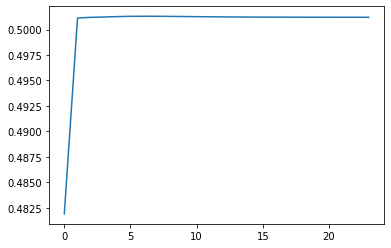

In [ ]:
sgd_regressor = SGDRegressor(learning_rate="constant", fit_intercept=True, random_state=42)
#sgd_regressor = SGDRegressor(learning_rate="constant", eta0=2.1, fit_intercept=True, rando
w_current, epsilon = np.random.random(num_features), 0.001
weight_evolution, r2_evolution = [], [] # изменения весов и ошибка на валидации
for step in list(range(800)):
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    sgd_regressor = sgd_regressor.partial_fit(X_train, y_train)
    weight_evolution.append(distance.euclidean(w_current, sgd_regressor.coef_))
    if weight_evolution[-1]<epsilon:
        print("Итарации остановлены на шаге %d" % step); break
    r2_evolution.append(r2_score(y_test, sgd_regressor.predict(X_test)))
    w_current = sgd_regressor.coef_.copy()
 
plt.plot(range(step), r2_evolution)

**Задача высокого уровня**

In [ ]:
def gradient (X, y, w, alpha) -> np.array: #<--добавляем альфу
 #кол-во примеров в обучающей выборке
 n = X.shape[0]
 # прогноз
 y_hat = X.dot(w.T)
 # вычисляем ошибку
 error = y - y_hat
 # градиент
 grad = (np.multiply(X, error) + 2*alpha*w).sum(axis=0)*(-1)*2/n #<--добавляем альфу
 return grad, error
def eval_w_next(X, y, eta, w_current, alpha): #<--добавляем альфу
 # вычисляем градиент
 grad, error = gradient(X, y, w_current, alpha) #<--добавляем альфу
 # делаем шаг градиентного спуска
 w_next = w_current - eta*grad
 # проверяем условие сходимости
 weight_evolution = distance.euclidean(w_current, w_next)
 return (w_next, weight_evolution, grad)
def gradient_descent(X: np.array, y: np.array, eta=0.001, epsilon=0.001, alpha = 0.1) -> np.array:
    m = X.shape[1] # количество фичей
    # инициализируем рандомом веса
    w = np.random.random(m).reshape(1, -1)
    w_next, weight_evolution, grad = eval_w_next(X, y, eta, w, alpha)
    step = 0
    # повторяем до сходимости вектора весов
    while weight_evolution > epsilon:
        w = w_next
        w_next, weight_evolution, grad = eval_w_next(X, y, eta, w, alpha) #<--добавляем аль
        step += 1
        if step % 10 ==0:
            print("step %s |w-w_next|=%.5f, grad=%s" % (step, weight_evolution, grad))
    return step, w

In [ ]:
# трансформируем плоский массив X в вектор-столбец
X = data['x_train'].values.reshape(-1, 1)
n = X.shape[0]
# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X = np.hstack([np.ones(n).reshape(-1,1), X])
w = gradient_descent(X, data['y_train'].values.reshape(-1, 1))

step 10 |w-w_next|=0.00913, grad=[1.35842136 9.03036097]
step 20 |w-w_next|=0.00681, grad=[0.81219006 6.76344377]
step 30 |w-w_next|=0.00509, grad=[0.40596475 5.07757699]
step 40 |w-w_next|=0.00383, grad=[0.10385951 3.82382743]
step 50 |w-w_next|=0.00289, grad=[-0.12081343  2.89143602]
step 60 |w-w_next|=0.00222, grad=[-0.2879013   2.19803315]
step 70 |w-w_next|=0.00173, grad=[-0.41216415  1.68236194]
step 80 |w-w_next|=0.00139, grad=[-0.50457876  1.29886672]
step 90 |w-w_next|=0.00116, grad=[-0.57330838  1.01366851]
step 100 |w-w_next|=0.00102, grad=[-0.62442389  0.80157209]
